In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
import os
from tqdm import tqdm
import pickle
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

warnings.filterwarnings("ignore")

In [70]:
# --- 1. Load and Aggregate Data ---
csv_path = "sensor_data.csv"  
df = pd.read_csv(csv_path, parse_dates=['timestamp'])
df = df.sort_values('timestamp').set_index('timestamp')
df = df.fillna(method='ffill').fillna(0)

print(f"Original data: {len(df)} records at {pd.infer_freq(df.index)} frequency")

# Aggregate to 15-minute intervals
def aggregate_data(df, freq='15T'):
    sensor_cols = [c for c in df.columns if c not in ['hour', 'minute', 'day', 'month', 'weekday', 'is_weekend']]
    
    df_agg = df[sensor_cols].resample(freq).sum()
    
    # Recreate time features
    df_agg['hour'] = df_agg.index.hour
    df_agg['minute'] = df_agg.index.minute
    df_agg['day'] = df_agg.index.day
    df_agg['month'] = df_agg.index.month
    df_agg['weekday'] = df_agg.index.weekday
    df_agg['is_weekend'] = df_agg.index.weekday.isin([5, 6]).astype(int)
    
    return df_agg

df = aggregate_data(df, '15T')
print(f"Aggregated data: {len(df)} records at {pd.infer_freq(df.index)} frequency")

Original data: 2400 records at 3min frequency
Aggregated data: 480 records at 15min frequency


In [71]:
# --- 2. Separate sensor columns from time columns ---
time_cols = ['hour', 'minute', 'day', 'month', 'weekday', 'is_weekend']
sensor_cols = [c for c in df.columns if c not in time_cols]

print(f"✅ Processing {len(sensor_cols)} sensors at 15-minute resolution")
print(f"Sample sensors: {sensor_cols[:5]}...")

# --- 2.1 Remove GASA-06-B sensors ---
print("🗑️ Removing GASA-06-B sensors...")

# Define sensors to remove
sensors_to_remove = ['GASA-06-B_95', 'GASA-06-B_275']

# Track changes
original_sensor_count = len(sensor_cols)
removed_sensors = []

# Remove specified sensors
for sensor in sensors_to_remove:
    if sensor in df.columns:
        df = df.drop(columns=[sensor])
        removed_sensors.append(sensor)
        print(f"   Removed: {sensor}")
    else:
        print(f"   ⚠️ {sensor} not found in data")

# Update sensor columns list after removal
sensor_cols = [c for c in df.columns if c not in time_cols]
print(f"✅ After removal: {len(sensor_cols)} sensors (was {original_sensor_count})")
print(f"Sample sensors after removal: {sensor_cols[:5]}...")

# Print removal summary
if removed_sensors:
    print(f"📊 Removal summary: {removed_sensors}")

# --- 2.2 Save the modified CSV ---
modified_csv_path = "sensor_data_modified.csv"
df.reset_index().to_csv(modified_csv_path, index=False)
print(f"💾 Modified data saved to: {modified_csv_path}")

# --- 3. Detect frequency and set parameters ---
freq = pd.infer_freq(df.index)
step_minutes = 15  # We know this now
SEASONAL_PERIODS = int(24 * 60 / step_minutes)  # 96 for 15-min data
FORECAST_STEPS = min(SEASONAL_PERIODS, 96)  # Forecast one day max

print(f"⏱ 15-minute data → Seasonal period = {SEASONAL_PERIODS}")

✅ Processing 74 sensors at 15-minute resolution
Sample sensors: ['CMSA-GAKH-01_0', 'CMSA-GAKH-01_180', 'CMSA-GAWW-11_120', 'CMSA-GAWW-11_300', 'CMSA-GAWW-12_115']...
🗑️ Removing GASA-06-B sensors...
   Removed: GASA-06-B_95
   Removed: GASA-06-B_275
✅ After removal: 72 sensors (was 74)
Sample sensors after removal: ['CMSA-GAKH-01_0', 'CMSA-GAKH-01_180', 'CMSA-GAWW-11_120', 'CMSA-GAWW-11_300', 'CMSA-GAWW-12_115']...
📊 Removal summary: ['GASA-06-B_95', 'GASA-06-B_275']
💾 Modified data saved to: sensor_data_modified.csv
⏱ 15-minute data → Seasonal period = 96


In [11]:
# --- 4. Improved SARIMAX modeling ---
def create_future_time_features(last_timestamp, steps, freq='15T'):
    """Create time features for future predictions without data leakage"""
    future_dates = pd.date_range(
        start=last_timestamp + pd.Timedelta(freq),
        periods=steps,
        freq=freq
    )
    
    return pd.DataFrame({
        'hour': future_dates.hour,
        'minute': future_dates.minute,
        'day': future_dates.day,
        'month': future_dates.month,
        'weekday': future_dates.weekday,
        'is_weekend': future_dates.weekday.isin([5, 6]).astype(int)
    }, index=future_dates)

In [ ]:
%pip install xgboost joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
import os
from tqdm import tqdm
import joblib  # For saving/loading models
import json

warnings.filterwarnings("ignore")

# --- 1. Load and Aggregate Data ---
csv_path = "sensor_data_modified.csv"  
df = pd.read_csv(csv_path, parse_dates=['timestamp'])
df = df.sort_values('timestamp').set_index('timestamp')
df = df.fillna(method='ffill').fillna(0)

print(f"Original data: {len(df)} records at {pd.infer_freq(df.index)} frequency")

# Aggregate to 15-minute intervals
def aggregate_data(df, freq='15T'):
    sensor_cols = [c for c in df.columns if c not in ['hour', 'minute', 'day', 'month', 'weekday', 'is_weekend']]
    
    df_agg = df[sensor_cols].resample(freq).sum()
    
    # Recreate time features
    df_agg['hour'] = df_agg.index.hour
    df_agg['minute'] = df_agg.index.minute
    df_agg['day'] = df_agg.index.day
    df_agg['month'] = df_agg.index.month
    df_agg['weekday'] = df_agg.index.weekday
    df_agg['is_weekend'] = df_agg.index.weekday.isin([5, 6]).astype(int)
    
    return df_agg

df = aggregate_data(df, '15T')
print(f"Aggregated data: {len(df)} records at {pd.infer_freq(df.index)} frequency")

# --- 2. Separate sensor columns from time columns ---
time_cols = ['hour', 'minute', 'day', 'month', 'weekday', 'is_weekend']
sensor_cols = [c for c in df.columns if c not in time_cols]

print(f"✅ Processing {len(sensor_cols)} sensors at 15-minute resolution")
print(f"Sample sensors: {sensor_cols[:5]}...")

# --- 3. Create lag features for time series ---
def create_lag_features(df, sensor_cols, lag_periods=[1, 2, 3, 4, 96, 97, 98]):  # 1-4 periods + daily seasonality
    """Create lagged features for all sensor columns"""
    df_lagged = df.copy()
    
    for col in sensor_cols:
        for lag in lag_periods:
            df_lagged[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Rolling statistics
    for col in sensor_cols:
        df_lagged[f'{col}_rolling_mean_4'] = df[col].rolling(window=4, min_periods=1).mean()
        df_lagged[f'{col}_rolling_std_4'] = df[col].rolling(window=4, min_periods=1).std()
        df_lagged[f'{col}_rolling_mean_96'] = df[col].rolling(window=96, min_periods=1).mean()  # Daily pattern
    
    return df_lagged.fillna(method='bfill').fillna(0)

# --- 4. Create cyclical time features ---
def create_cyclical_features(df):
    """Convert time features to cyclical format"""
    df_cyclic = df.copy()
    
    # Cyclical encoding for hour and minute
    df_cyclic['hour_sin'] = np.sin(2 * np.pi * df_cyclic['hour'] / 24)
    df_cyclic['hour_cos'] = np.cos(2 * np.pi * df_cyclic['hour'] / 24)
    df_cyclic['minute_sin'] = np.sin(2 * np.pi * df_cyclic['minute'] / 60)
    df_cyclic['minute_cos'] = np.cos(2 * np.pi * df_cyclic['minute'] / 60)
    
    # Day of week cyclical
    df_cyclic['weekday_sin'] = np.sin(2 * np.pi * df_cyclic['weekday'] / 7)
    df_cyclic['weekday_cos'] = np.cos(2 * np.pi * df_cyclic['weekday'] / 7)
    
    # Month cyclical
    df_cyclic['month_sin'] = np.sin(2 * np.pi * df_cyclic['month'] / 12)
    df_cyclic['month_cos'] = np.cos(2 * np.pi * df_cyclic['month'] / 12)
    
    return df_cyclic

# --- 5. Prepare data for XGBoost ---
def prepare_xgboost_data(df, sensor_cols, forecast_horizon=96):
    """Prepare features and targets for multi-output XGBoost"""
    
    # Create lag features
    df_engineered = create_lag_features(df, sensor_cols)
    df_engineered = create_cyclical_features(df_engineered)
    
    # Define feature columns (exclude original time columns and use cyclical ones)
    feature_cols = [col for col in df_engineered.columns 
                   if any(x in col for x in ['_lag_', '_rolling_', '_sin', '_cos', 'is_weekend'])]
    
    # Prepare training data
    X = df_engineered[feature_cols]
    y = df_engineered[sensor_cols]
    
    # Train-test split (last forecast_horizon points for testing)
    train_size = len(X) - forecast_horizon
    if train_size < forecast_horizon * 2:  # Ensure sufficient training data
        train_size = max(int(0.8 * len(X)), forecast_horizon * 2)
    
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:train_size + forecast_horizon]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:train_size + forecast_horizon]
    
    return X_train, X_test, y_train, y_test, feature_cols

# --- 6. XGBoost Multi-Output Forecasting ---
def train_xgboost_forecaster(X_train, y_train, X_test, y_test, sensor_cols):
    """Train XGBoost model for multi-output forecasting"""
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train multi-output XGBoost
    model = MultiOutputRegressor(
        XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
    )
    
    print("Training XGBoost model...")
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    print("Making predictions...")
    y_pred = model.predict(X_test_scaled)
    y_pred = np.maximum(y_pred, 0)  # Ensure non-negative predictions
    
    # Convert to DataFrame
    y_pred_df = pd.DataFrame(y_pred, columns=sensor_cols, index=y_test.index)
    
    # Calculate MAE for each sensor
    mae_scores = {}
    for col in sensor_cols:
        mae_scores[col] = mean_absolute_error(y_test[col], y_pred_df[col])
    
    return model, scaler, y_pred_df, mae_scores

# --- 7. Save Model Function ---
def save_model_pipeline(model, scaler, feature_cols, sensor_cols, model_path="sensor_forecast_model"):
    """Save the entire model pipeline for later use"""
    
    # Create model directory if it doesn't exist
    os.makedirs(model_path, exist_ok=True)
    
    # Save individual components
    joblib.dump(model, f"{model_path}/xgboost_model.joblib")
    joblib.dump(scaler, f"{model_path}/scaler.joblib")
    
    # Save feature and sensor lists
    with open(f"{model_path}/feature_cols.json", 'w') as f:
        json.dump(feature_cols, f)
    
    with open(f"{model_path}/sensor_cols.json", 'w') as f:
        json.dump(sensor_cols, f)
    
    print(f"✅ Model pipeline saved to {model_path}/")

# --- 8. Main forecasting pipeline ---
print("🔧 Preparing features for XGBoost...")
X_train, X_test, y_train, y_test, feature_cols = prepare_xgboost_data(df, sensor_cols)

print(f"📊 Training data: {len(X_train)} samples")
print(f"📊 Test data: {len(X_test)} samples")
print(f"🔧 Using {len(feature_cols)} features")

# Train model
model, scaler, y_pred, mae_scores = train_xgboost_forecaster(
    X_train, y_train, X_test, y_test, sensor_cols
)

# --- 9. Save the trained model ---
save_model_pipeline(model, scaler, feature_cols, sensor_cols, "sensor_forecast_model")

# --- 10. Results and Visualization ---
print(f"\n✅ XGBoost training completed!")
print(f"📈 Average MAE across all sensors: {np.mean(list(mae_scores.values())):.2f}")

# Save results
results = []
for col in sensor_cols:
    for timestamp, actual, forecast in zip(y_test.index, y_test[col], y_pred[col]):
        results.append({
            'timestamp': timestamp,
            'sensor': col,
            'actual': actual,
            'forecast': forecast,
            'mae': mae_scores[col]
        })

all_forecasts = pd.DataFrame(results)
all_forecasts.to_csv("sensor_forecasts_15min_xgboost.csv", index=False)
print("✅ Forecasts saved to: sensor_forecasts_15min_xgboost.csv")

# --- 11. Plot top sensors by error for inspection ---
top_sensors_by_error = sorted(mae_scores.items(), key=lambda x: x[1], reverse=True)[:5]

plt.figure(figsize=(15, 10))
for i, (sensor, mae) in enumerate(top_sensors_by_error):
    plt.subplot(3, 2, i + 1)
    
    # Plot last part of training and test period
    train_cutoff = len(X_train) - min(200, len(X_train) // 2)
    train_plot = y_train[sensor].iloc[train_cutoff:]
    test_plot = y_test[sensor]
    pred_plot = y_pred[sensor]
    
    plt.plot(train_plot.index, train_plot.values, label='Train', color='steelblue', alpha=0.7)
    plt.plot(test_plot.index, test_plot.values, label='Actual', color='black', linewidth=2)
    plt.plot(test_plot.index, pred_plot.values, label='Forecast', color='red', linestyle='--', linewidth=2)
    plt.title(f"{sensor}\nMAE: {mae:.2f}")
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("xgboost_forecasts_top_sensors.png", dpi=150, bbox_inches='tight')
plt.close()

# --- 12. Feature Importance (for first target) ---
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.estimators_[0].feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances for XGBoost')
plt.tight_layout()
plt.savefig("xgboost_feature_importance.png", dpi=150, bbox_inches='tight')
plt.close()

print(f"\n🎯 Completed! Forecasted {len(sensor_cols)} sensors simultaneously using XGBoost")
print(f"📊 Model performance summary:")
print(f"   - Best sensor MAE: {min(mae_scores.values()):.2f}")
print(f"   - Worst sensor MAE: {max(mae_scores.values()):.2f}")
print(f"   - Median sensor MAE: {np.median(list(mae_scores.values())):.2f}")

Note: you may need to restart the kernel to use updated packages.
Original data: 2400 records at 3min frequency
Aggregated data: 480 records at 15min frequency
✅ Processing 74 sensors at 15-minute resolution
Sample sensors: ['CMSA-GAKH-01_0', 'CMSA-GAKH-01_180', 'CMSA-GAWW-11_120', 'CMSA-GAWW-11_300', 'CMSA-GAWW-12_115']...
🔧 Preparing features for XGBoost...
📊 Training data: 384 samples
📊 Test data: 96 samples
🔧 Using 749 features
Training XGBoost model...


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import joblib
import json
from datetime import datetime, timedelta

def load_forecast_model(model_path="sensor_forecast_model"):
    """Load the trained model and all components"""
    model = joblib.load(f"{model_path}/xgboost_model.joblib")
    scaler = joblib.load(f"{model_path}/scaler.joblib")
    
    with open(f"{model_path}/feature_cols.json", 'r') as f:
        feature_cols = json.load(f)
        
    with open(f"{model_path}/sensor_cols.json", 'r') as f:
        sensor_cols = json.load(f)
    
    print(f"✅ Model loaded successfully for {len(sensor_cols)} sensors")
    return model, scaler, feature_cols, sensor_cols

def aggregate_to_15min(df_3min):
    """Aggregate 3-minute data to 15-minute intervals"""
    # Get sensor columns (exclude time features)
    sensor_cols = [col for col in df_3min.columns if col not in ['hour', 'minute', 'day', 'month', 'weekday', 'is_weekend']]
    
    # Aggregate sensor data
    df_15min = df_3min[sensor_cols].resample('15T').sum()
    
    # Recreate time features
    df_15min['hour'] = df_15min.index.hour
    df_15min['minute'] = df_15min.index.minute
    df_15min['day'] = df_15min.index.day
    df_15min['month'] = df_15min.index.month
    df_15min['weekday'] = df_15min.index.weekday
    df_15min['is_weekend'] = df_15min.index.weekday.isin([5, 6]).astype(int)
    
    return df_15min

def create_lag_features(df, sensor_cols, lag_periods=[1, 2, 3, 4, 96, 97, 98]):
    """Create lagged features using ACTUAL historical data"""
    df_lagged = df.copy()
    
    for col in sensor_cols:
        for lag in lag_periods:
            df_lagged[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Rolling statistics
    for col in sensor_cols:
        df_lagged[f'{col}_rolling_mean_4'] = df[col].rolling(window=4, min_periods=1).mean()
        df_lagged[f'{col}_rolling_std_4'] = df[col].rolling(window=4, min_periods=1).std()
        df_lagged[f'{col}_rolling_mean_96'] = df[col].rolling(window=96, min_periods=1).mean()
    
    return df_lagged.fillna(method='bfill').fillna(0)

def create_cyclical_features(df):
    """Convert time features to cyclical format"""
    df_cyclic = df.copy()
    
    # Ensure all time features are numeric, not methods
    for col in ['hour', 'minute', 'day', 'month', 'weekday']:
        if col in df_cyclic.columns:
            # Convert to numeric, coercing any non-numeric to NaN then filling
            df_cyclic[col] = pd.to_numeric(df_cyclic[col], errors='coerce').fillna(0)
    
    # Cyclical encoding for hour and minute
    df_cyclic['hour_sin'] = np.sin(2 * np.pi * df_cyclic['hour'] / 24)
    df_cyclic['hour_cos'] = np.cos(2 * np.pi * df_cyclic['hour'] / 24)
    df_cyclic['minute_sin'] = np.sin(2 * np.pi * df_cyclic['minute'] / 60)
    df_cyclic['minute_cos'] = np.cos(2 * np.pi * df_cyclic['minute'] / 60)
    
    # Day of week cyclical
    df_cyclic['weekday_sin'] = np.sin(2 * np.pi * df_cyclic['weekday'] / 7)
    df_cyclic['weekday_cos'] = np.cos(2 * np.pi * df_cyclic['weekday'] / 7)
    
    # Month cyclical
    df_cyclic['month_sin'] = np.sin(2 * np.pi * df_cyclic['month'] / 12)
    df_cyclic['month_cos'] = np.cos(2 * np.pi * df_cyclic['month'] / 12)
    
    return df_cyclic

def update_features_with_forecast(df, forecast_values, sensor_cols, forecast_time):
    """
    Update the DataFrame with new forecast values and recompute lag features
    """
    # Create new row with forecast values
    new_row = pd.DataFrame([forecast_values], columns=sensor_cols, index=[forecast_time])
    
    # Add time features for the new time - ensure they are numeric values, not methods
    new_row['hour'] = float(forecast_time.hour)
    new_row['minute'] = float(forecast_time.minute)
    new_row['day'] = float(forecast_time.day)
    new_row['month'] = float(forecast_time.month)
    new_row['weekday'] = float(forecast_time.weekday())
    new_row['is_weekend'] = 1.0 if forecast_time.weekday() in [5, 6] else 0.0
    
    # Append to DataFrame
    df_updated = pd.concat([df, new_row])
    
    # Ensure we only keep numeric columns for feature engineering
    numeric_cols = [col for col in df_updated.columns if col not in ['timestamp', 'index']]
    df_updated = df_updated[numeric_cols]
    
    # Recompute lag features for the entire updated DataFrame
    df_with_lags = create_lag_features(df_updated, sensor_cols)
    df_with_features = create_cyclical_features(df_with_lags)
    
    return df_with_features

def prepare_features_for_time(df, feature_cols, target_time):
    """
    Extract features for a specific time from the prepared DataFrame
    """
    if target_time in df.index:
        return df[feature_cols].loc[[target_time]]
    else:
        # If time not found, use the latest available
        return df[feature_cols].iloc[[-1]]

def forecast_next_2_hours(model, scaler, feature_cols, sensor_cols, recent_data, forecast_datetime):
    """
    Forecast the next 2 hours (8 steps) using RECURSIVE forecasting
    """
    print(f"🎯 Forecasting next 2 hours starting from {forecast_datetime}")
    
    # Remove timezone from data if present
    recent_data = recent_data.copy()
    if recent_data.index.tz is not None:
        recent_data.index = recent_data.index.tz_localize(None)
    
    # Ensure forecast_datetime is timezone-naive
    if hasattr(forecast_datetime, 'tzinfo') and forecast_datetime.tzinfo is not None:
        forecast_datetime = forecast_datetime.replace(tzinfo=None)
    
    # Filter data to ONLY include data BEFORE forecast_datetime
    historical_data = recent_data[recent_data.index < forecast_datetime]
    
    if len(historical_data) == 0:
        raise ValueError(f"No historical data found before {forecast_datetime}")
    
    print(f"📊 Using {len(historical_data)} historical records up to {historical_data.index[-1]}")
    
    # Create future timestamps for the forecast period
    future_dates = pd.date_range(
        start=forecast_datetime,
        periods=8,  # 2 hours = 8 steps of 15min
        freq='15T'
    )
    
    # Prepare initial features using ACTUAL historical data
    df_with_features = create_lag_features(historical_data, sensor_cols)
    df_with_features = create_cyclical_features(df_with_features)
    
    # Ensure all data is numeric
    for col in df_with_features.columns:
        df_with_features[col] = pd.to_numeric(df_with_features[col], errors='coerce').fillna(0)
    
    all_forecasts = []
    current_df = df_with_features
    
    # Recursive forecasting: predict one step, update features, predict next step
    for i, forecast_time in enumerate(future_dates):
        print(f"🔮 Forecasting step {i+1}/8: {forecast_time}")
        
        # Prepare features for current forecast time
        current_features = prepare_features_for_time(current_df, feature_cols, current_df.index[-1])
        
        # Debug: Show feature variation for this step
        if i < 2:  # Only show for first 2 steps to avoid too much output
            print(f"   Feature variation for step {i+1}:")
            for col in current_features.columns[:3]:
                print(f"      {col}: {current_features[col].iloc[0]:.4f}")
        
        # Scale features and make prediction
        features_scaled = scaler.transform(current_features)
        forecast = model.predict(features_scaled)
        forecast = np.maximum(forecast, 0)  # Ensure non-negative
        
        # Store forecast
        all_forecasts.append(forecast[0])
        
        # Update DataFrame with this forecast for the next prediction
        if i < len(future_dates) - 1:  # Don't update after the last prediction
            current_df = update_features_with_forecast(
                current_df, 
                forecast[0], 
                sensor_cols, 
                forecast_time
            )
    
    # Create results DataFrame
    forecast_results = pd.DataFrame(all_forecasts, columns=sensor_cols, index=future_dates)
    
    return forecast_results

# --- USAGE EXAMPLE ---

# 1. Load your saved model
print("📥 Loading trained model...")
model, scaler, feature_cols, sensor_cols = load_forecast_model("sensor_forecast_model")

# 2. Load and prepare your 3-minute data
print("📊 Loading and preparing data...")
df_3min = pd.read_csv("Sensor_data.csv", parse_dates=['timestamp'])
df_3min = df_3min.set_index('timestamp')

# Add time features to match your training data structure
df_3min['hour'] = df_3min.index.hour
df_3min['minute'] = df_3min.index.minute
df_3min['day'] = df_3min.index.day
df_3min['month'] = df_3min.index.month
df_3min['weekday'] = df_3min.index.weekday
df_3min['is_weekend'] = df_3min.index.weekday.isin([5, 6]).astype(int)

# Ensure all time features are numeric
for col in ['hour', 'minute', 'day', 'month', 'weekday', 'is_weekend']:
    df_3min[col] = pd.to_numeric(df_3min[col], errors='coerce').fillna(0)

# Aggregate to 15-minute intervals
print("🔄 Aggregating to 15-minute intervals...")
df_15min = aggregate_to_15min(df_3min)

print(f"✅ Aggregated from {len(df_3min)} 3-min records to {len(df_15min)} 15-min records")

# 3. Set forecast time
forecast_start = datetime(2025, 8, 21, 12, 0, 0)
tempo_X = forecast_start
print(f"⏰ Forecast start time: {forecast_start}")

# 4. Generate forecast
print("🔮 Generating 2-hour forecast...")
try:
    forecasts = forecast_next_2_hours(
        model=model,
        scaler=scaler,
        feature_cols=feature_cols,
        sensor_cols=sensor_cols,
        recent_data=df_15min,
        forecast_datetime=forecast_start
    )
    
    print("\n📈 FORECAST RESULTS (Next 2 Hours):")
    print(forecasts)
    
    # Check if forecasts have meaningful variation
    print("\n🔍 Forecast variation analysis:")
    for sensor in forecasts.columns[:3]:
        variation = forecasts[sensor].std() / forecasts[sensor].mean() if forecasts[sensor].mean() > 0 else 0
        print(f"   {sensor}: CV = {variation:.4f} (std/mean)")
    
    # Save results
    forecasts.to_csv("2_hour_forecast_recursive.csv")
    print("💾 Forecasts saved to: 2_hour_forecast_recursive.csv")
    
except Exception as e:
    print(f"❌ Error during forecasting: {e}")
    import traceback
    traceback.print_exc()

📥 Loading trained model...
✅ Model loaded successfully for 74 sensors
📊 Loading and preparing data...
🔄 Aggregating to 15-minute intervals...
✅ Aggregated from 2400 3-min records to 480 15-min records
⏰ Forecast start time: 2025-08-21 12:00:00
🔮 Generating 2-hour forecast...
🎯 Forecasting next 2 hours starting from 2025-08-21 12:00:00
📊 Using 144 historical records up to 2025-08-21 11:45:00
🔮 Forecasting step 1/8: 2025-08-21 12:00:00
   Feature variation for step 1:
      is_weekend: 0.0000
      CMSA-GAKH-01_0_lag_1: 268.0000
      CMSA-GAKH-01_0_lag_2: 183.0000
🔮 Forecasting step 2/8: 2025-08-21 12:15:00
   Feature variation for step 2:
      is_weekend: 0.0000
      CMSA-GAKH-01_0_lag_1: 354.0000
      CMSA-GAKH-01_0_lag_2: 268.0000
🔮 Forecasting step 3/8: 2025-08-21 12:30:00
🔮 Forecasting step 4/8: 2025-08-21 12:45:00
🔮 Forecasting step 5/8: 2025-08-21 13:00:00
🔮 Forecasting step 6/8: 2025-08-21 13:15:00
🔮 Forecasting step 7/8: 2025-08-21 13:30:00
🔮 Forecasting step 8/8: 2025-08-21

🔍 Starting forecast comparison analysis...
📊 Loading forecast data...
📊 Loading actual data...
🕐 Removing timezone information to avoid conflicts...
🔍 Original actual data frequency: 2400 records
🔍 Forecast data frequency: 8 records
🔄 Aggregating actual data to 15-minute intervals...
✅ Aggregated actual data to 480 15-minute records
🔍 Found 8 forecast records
📅 Forecast period: 2025-08-21 12:00:00 to 2025-08-21 13:45:00
📈 Comparing 74 common sensors
🔄 Aligning forecast and actual data by timestamp...
✅ Successfully aligned 8 timestamp records

📊 OVERALL FORECAST PERFORMANCE SUMMARY
Average MAE across all sensors: 47.83
Average RMSE across all sensors: 57.65
Average MAPE across all sensors: 4435407321.30%
Best sensor (lowest MAE): GASA-06_95 (MAE: 0.00)
Worst sensor (highest MAE): GASA-03_105 (MAE: 244.82)


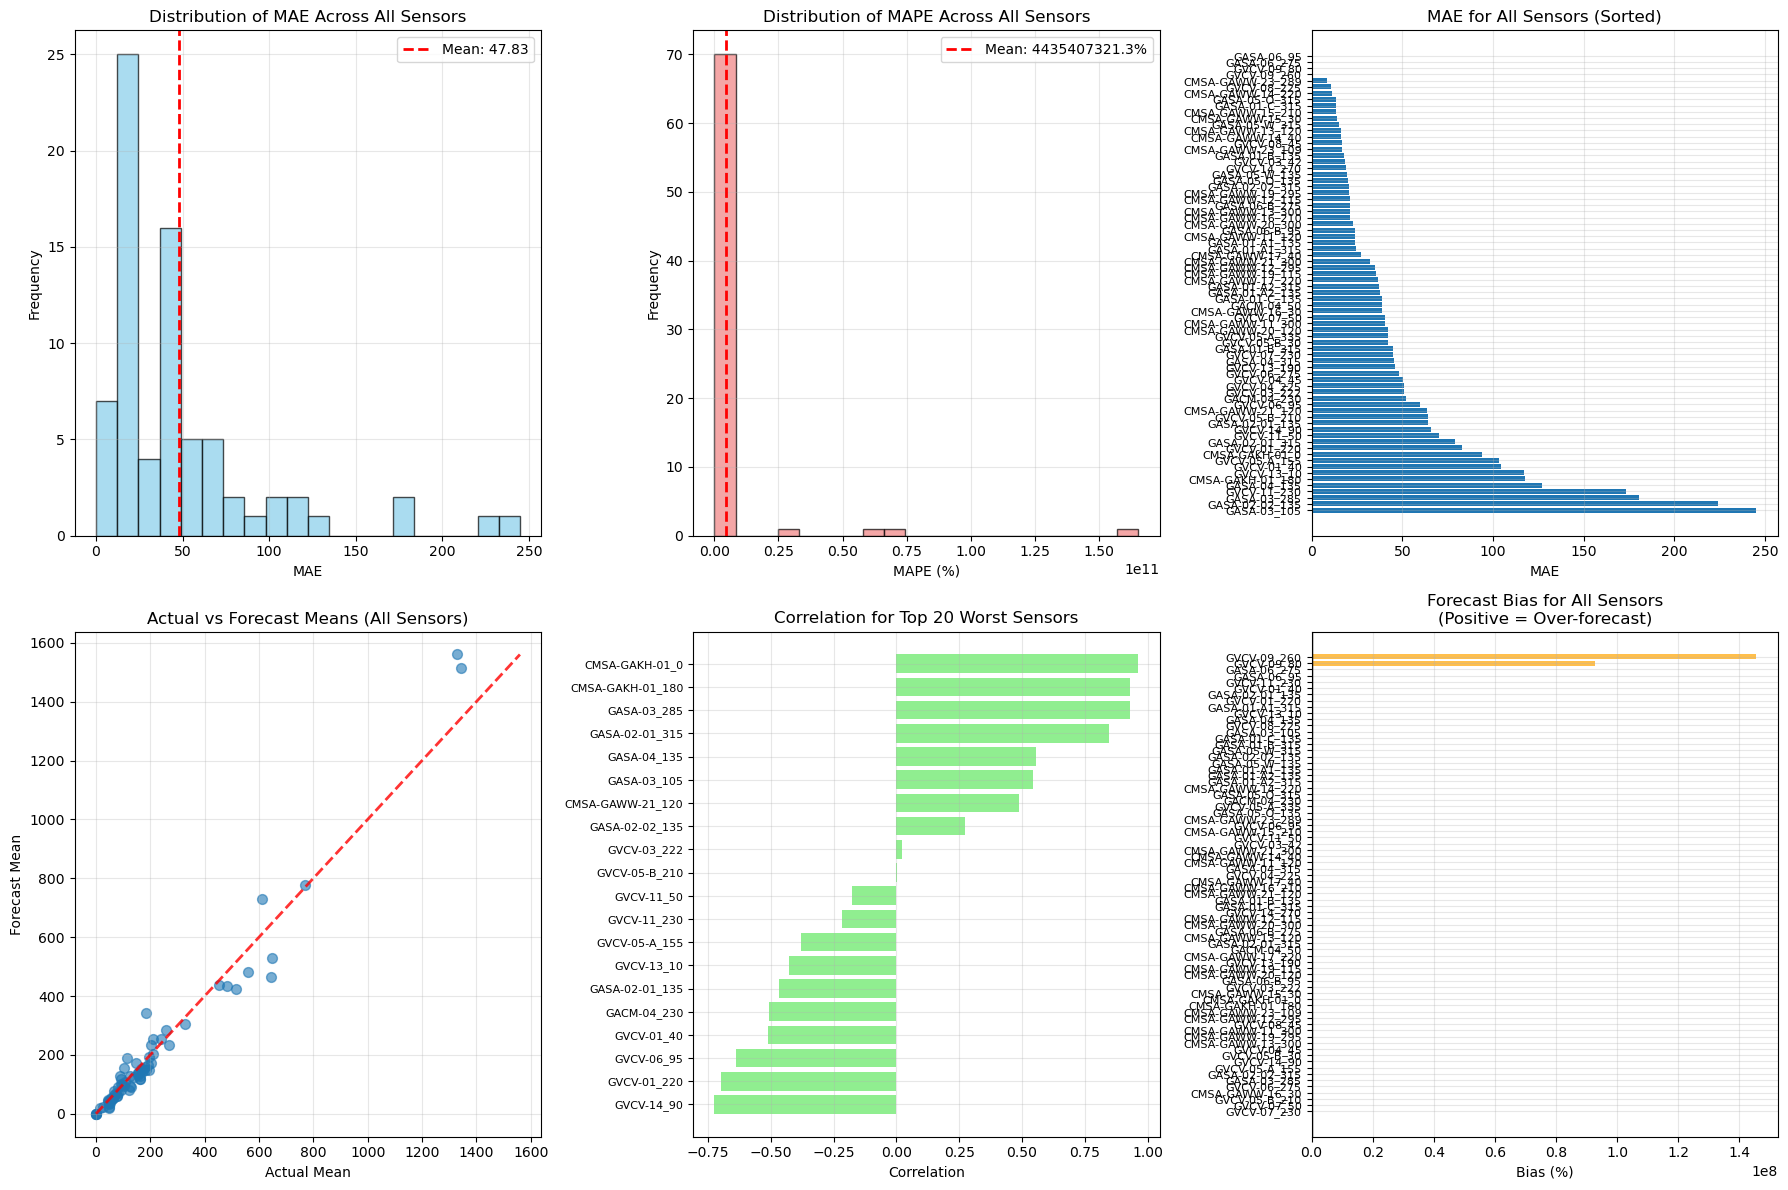

📊 Creating plots for all 74 sensors in a 19x4 grid...


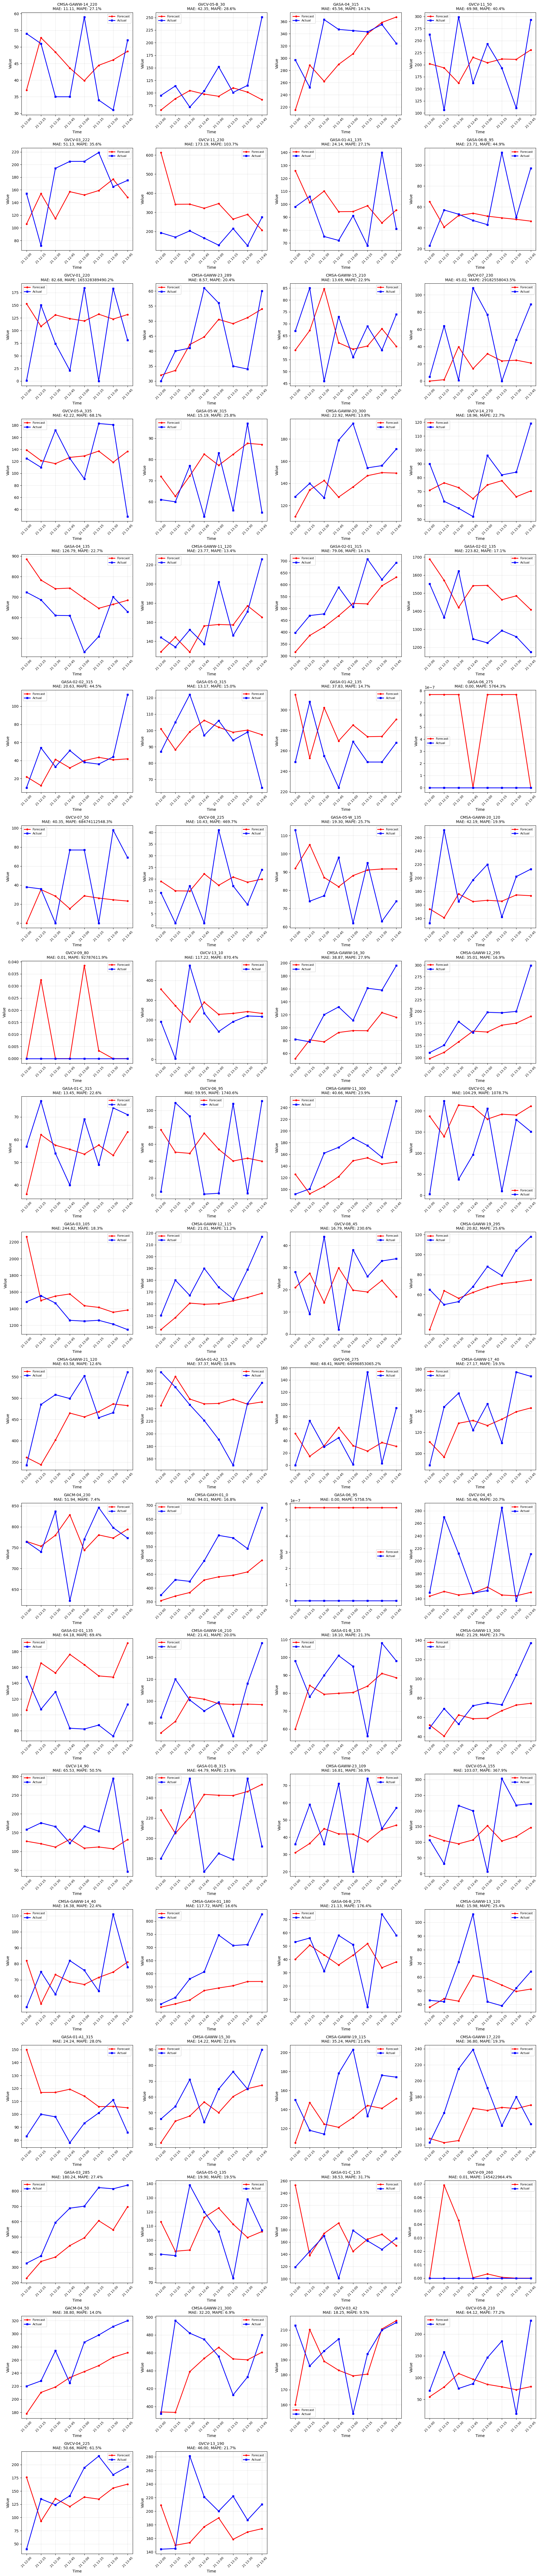

💾 Detailed comparison report saved to: forecast_comparison_report.csv

📋 DETAILED PERFORMANCE SUMMARY FOR ALL SENSORS

🔴 TOP 10 WORST-PERFORMING SENSORS (by MAE):
------------------------------------------------------------
 1. GASA-03_105                    MAE:  244.82 | MAPE:   18.3% | Bias:  +17.3%
 2. GASA-02-02_135                 MAE:  223.82 | MAPE:   17.1% | Bias:  +12.9%
 3. GASA-03_285                    MAE:  180.24 | MAPE:   27.4% | Bias:  -27.9%
 4. GVCV-11_230                    MAE:  173.19 | MAPE:  103.7% | Bias:  +84.9%
 5. GASA-04_135                    MAE:  126.79 | MAPE:   22.7% | Bias:  +19.2%
 6. CMSA-GAKH-01_180               MAE:  117.72 | MAPE:   16.6% | Bias:  -18.2%
 7. GVCV-13_10                     MAE:  117.22 | MAPE:  870.4% | Bias:  +22.1%
 8. GVCV-01_40                     MAE:  104.29 | MAPE: 1078.7% | Bias:  +68.3%
 9. GVCV-05-A_155                  MAE:  103.07 | MAPE:  367.9% | Bias:  -27.2%
10. CMSA-GAKH-01_0                 MAE:   94.01 | MAPE: 

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import seaborn as sns
import math

def aggregate_actual_data_to_15min(actual_data):
    """Aggregate 3-minute actual data to 15-minute intervals to match forecasts"""
    # Get sensor columns (exclude time features)
    sensor_cols = [col for col in actual_data.columns if col not in ['hour', 'minute', 'day', 'month', 'weekday', 'is_weekend']]
    
    # Aggregate sensor data
    actual_15min = actual_data[sensor_cols].resample('15T').sum()
    
    # Recreate time features for the aggregated data
    actual_15min['hour'] = actual_15min.index.hour
    actual_15min['minute'] = actual_15min.index.minute
    actual_15min['day'] = actual_15min.index.day
    actual_15min['month'] = actual_15min.index.month
    actual_15min['weekday'] = actual_15min.index.weekday
    actual_15min['is_weekend'] = actual_15min.index.weekday.isin([5, 6]).astype(int)
    
    return actual_15min

def load_and_compare_forecasts(forecast_file, actual_data_file, forecast_start_time=None):
    """
    Compare recursive forecasts with actual data
    """
    
    # Load the forecasts
    print("📊 Loading forecast data...")
    forecasts = pd.read_csv(forecast_file, parse_dates=['timestamp'])
    forecasts = forecasts.set_index('timestamp')
    
    # Load the actual data
    print("📊 Loading actual data...")
    actual_data = pd.read_csv(actual_data_file, parse_dates=['timestamp'])
    actual_data = actual_data.set_index('timestamp')
    
    # Remove timezone from both datasets to avoid conflicts
    print("🕐 Removing timezone information to avoid conflicts...")
    if forecasts.index.tz is not None:
        forecasts.index = forecasts.index.tz_localize(None)
    if actual_data.index.tz is not None:
        actual_data.index = actual_data.index.tz_localize(None)
    
    print(f"🔍 Original actual data frequency: {len(actual_data)} records")
    print(f"🔍 Forecast data frequency: {len(forecasts)} records")
    
    # Aggregate actual data to 15-minute intervals to match forecasts
    print("🔄 Aggregating actual data to 15-minute intervals...")
    actual_15min = aggregate_actual_data_to_15min(actual_data)
    print(f"✅ Aggregated actual data to {len(actual_15min)} 15-minute records")
    
    # If forecast_start_time is provided, filter to that specific forecast period
    if forecast_start_time:
        if isinstance(forecast_start_time, str):
            forecast_start_time = pd.to_datetime(forecast_start_time)
        
        # Ensure forecast_start_time is timezone-naive
        if hasattr(forecast_start_time, 'tzinfo') and forecast_start_time.tzinfo is not None:
            forecast_start_time = forecast_start_time.replace(tzinfo=None)
        
        # Find forecasts that start at this time (2-hour window)
        forecast_end = forecast_start_time + pd.Timedelta(hours=2)
        forecasts = forecasts[(forecasts.index >= forecast_start_time) & 
                             (forecasts.index < forecast_end)]
    
    print(f"🔍 Found {len(forecasts)} forecast records")
    if len(forecasts) > 0:
        print(f"📅 Forecast period: {forecasts.index.min()} to {forecasts.index.max()}")
    
    # Get common sensors between forecasts and actual data
    common_sensors = list(set(forecasts.columns) & set(actual_15min.columns))
    print(f"📈 Comparing {len(common_sensors)} common sensors")
    
    if len(common_sensors) == 0:
        print("❌ No common sensors found between forecast and actual data!")
        print(f"Forecast sensors: {list(forecasts.columns)[:10]}...")
        print(f"Actual sensors: {list(actual_15min.columns)[:10]}...")
        return pd.DataFrame(), forecasts, pd.DataFrame()
    
    # Align the data by timestamp using merge (handles timezone issues)
    print("🔄 Aligning forecast and actual data by timestamp...")
    comparison_data = forecasts[common_sensors].copy()
    comparison_data = comparison_data.merge(
        actual_15min[common_sensors], 
        left_index=True, 
        right_index=True, 
        how='inner',  # Only keep timestamps that exist in both
        suffixes=('_forecast', '_actual')
    )
    
    print(f"✅ Successfully aligned {len(comparison_data)} timestamp records")
    
    # Calculate metrics for each sensor
    comparison_results = []
    
    for sensor in common_sensors:
        actual_vals = comparison_data[f'{sensor}_actual']
        forecast_vals = comparison_data[f'{sensor}_forecast']
        
        # Only compare if we have actual data for this period
        if len(actual_vals) > 0 and not actual_vals.isna().all():
            mae = mean_absolute_error(actual_vals, forecast_vals)
            rmse = np.sqrt(mean_squared_error(actual_vals, forecast_vals))
            mape = np.mean(np.abs((actual_vals - forecast_vals) / (actual_vals + 1e-8))) * 100  # Avoid division by zero
            
            comparison_results.append({
                'sensor': sensor,
                'mae': mae,
                'rmse': rmse,
                'mape': mape,
                'actual_mean': actual_vals.mean(),
                'forecast_mean': forecast_vals.mean(),
                'actual_std': actual_vals.std(),
                'forecast_std': forecast_vals.std()
            })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_results)
    
    return comparison_df, forecasts, comparison_data

def plot_all_sensors_comparison(comparison_df, comparison_data):
    """
    Plot time series comparison for ALL sensors in a grid layout
    """
    if len(comparison_df) == 0:
        print("❌ No data to plot!")
        return
    
    sensors = comparison_df['sensor'].tolist()
    n_sensors = len(sensors)
    
    # Calculate grid dimensions
    cols = 4  # 4 columns
    rows = math.ceil(n_sensors / cols)
    
    print(f"📊 Creating plots for all {n_sensors} sensors in a {rows}x{cols} grid...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    
    # Flatten axes array for easy indexing
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for i, sensor in enumerate(sensors):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            # Get sensor data
            forecast_vals = comparison_data[f'{sensor}_forecast']
            actual_vals = comparison_data[f'{sensor}_actual']
            
            # Get metrics for this sensor
            sensor_metrics = comparison_df[comparison_df['sensor'] == sensor].iloc[0]
            mae = sensor_metrics['mae']
            mape = sensor_metrics['mape']
            
            # Plot
            ax.plot(comparison_data.index, forecast_vals, 'r-', label='Forecast', linewidth=2, marker='o', markersize=4)
            ax.plot(comparison_data.index, actual_vals, 'b-', label='Actual', linewidth=2, marker='s', markersize=4)
            ax.set_title(f'{sensor}\nMAE: {mae:.2f}, MAPE: {mape:.1f}%', fontsize=10)
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.legend(fontsize=8)
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(len(sensors), len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_comprehensive_summary(comparison_df, comparison_data):
    """
    Plot comprehensive summary with overall metrics and distributions
    """
    if len(comparison_df) == 0:
        print("❌ No data to plot!")
        return
    
    # 1. Overall metrics summary
    print("\n" + "="*50)
    print("📊 OVERALL FORECAST PERFORMANCE SUMMARY")
    print("="*50)
    print(f"Average MAE across all sensors: {comparison_df['mae'].mean():.2f}")
    print(f"Average RMSE across all sensors: {comparison_df['rmse'].mean():.2f}")
    print(f"Average MAPE across all sensors: {comparison_df['mape'].mean():.2f}%")
    print(f"Best sensor (lowest MAE): {comparison_df.loc[comparison_df['mae'].idxmin(), 'sensor']} "
          f"(MAE: {comparison_df['mae'].min():.2f})")
    print(f"Worst sensor (highest MAE): {comparison_df.loc[comparison_df['mae'].idxmax(), 'sensor']} "
          f"(MAE: {comparison_df['mae'].max():.2f})")
    
    # Create summary plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: MAE distribution (all sensors)
    axes[0, 0].hist(comparison_df['mae'], bins=20, alpha=0.7, edgecolor='black', color='skyblue')
    axes[0, 0].axvline(comparison_df['mae'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {comparison_df["mae"].mean():.2f}')
    axes[0, 0].set_xlabel('MAE')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of MAE Across All Sensors')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: MAPE distribution (all sensors)
    axes[0, 1].hist(comparison_df['mape'], bins=20, alpha=0.7, edgecolor='black', color='lightcoral')
    axes[0, 1].axvline(comparison_df['mape'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {comparison_df["mape"].mean():.1f}%')
    axes[0, 1].set_xlabel('MAPE (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of MAPE Across All Sensors')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: MAE sorted (all sensors)
    sorted_mae = comparison_df.sort_values('mae', ascending=False)
    axes[0, 2].barh(range(len(sorted_mae)), sorted_mae['mae'])
    axes[0, 2].set_yticks(range(len(sorted_mae)))
    axes[0, 2].set_yticklabels(sorted_mae['sensor'], fontsize=8)
    axes[0, 2].set_xlabel('MAE')
    axes[0, 2].set_title('MAE for All Sensors (Sorted)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Actual vs Forecast means scatter (all sensors)
    axes[1, 0].scatter(comparison_df['actual_mean'], comparison_df['forecast_mean'], alpha=0.6, s=50)
    max_val = max(comparison_df['actual_mean'].max(), comparison_df['forecast_mean'].max())
    axes[1, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2)
    axes[1, 0].set_xlabel('Actual Mean')
    axes[1, 0].set_ylabel('Forecast Mean')
    axes[1, 0].set_title('Actual vs Forecast Means (All Sensors)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Correlation heatmap (top 20 sensors by MAE)
    top_20_sensors = comparison_df.nlargest(20, 'mae')['sensor'].tolist()
    if len(top_20_sensors) > 1:
        # Prepare data for correlation
        corr_data = []
        for sensor in top_20_sensors:
            corr_data.append({
                'sensor': sensor,
                'correlation': np.corrcoef(
                    comparison_data[f'{sensor}_actual'],
                    comparison_data[f'{sensor}_forecast']
                )[0, 1]
            })
        corr_df = pd.DataFrame(corr_data)
        corr_df = corr_df.sort_values('correlation')
        
        axes[1, 1].barh(range(len(corr_df)), corr_df['correlation'], color='lightgreen')
        axes[1, 1].set_yticks(range(len(corr_df)))
        axes[1, 1].set_yticklabels(corr_df['sensor'], fontsize=8)
        axes[1, 1].set_xlabel('Correlation')
        axes[1, 1].set_title('Correlation for Top 20 Worst Sensors')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Not enough sensors\nfor correlation plot', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Correlation Analysis')
    
    # Plot 6: Bias analysis (all sensors)
    bias_data = []
    for sensor in comparison_df['sensor']:
        actual_mean = comparison_df[comparison_df['sensor'] == sensor]['actual_mean'].iloc[0]
        forecast_mean = comparison_df[comparison_df['sensor'] == sensor]['forecast_mean'].iloc[0]
        bias = ((forecast_mean - actual_mean) / (actual_mean + 1e-8)) * 100
        bias_data.append({'sensor': sensor, 'bias': bias})
    
    bias_df = pd.DataFrame(bias_data)
    bias_df = bias_df.sort_values('bias')
    
    axes[1, 2].barh(range(len(bias_df)), bias_df['bias'], color='orange', alpha=0.7)
    axes[1, 2].axvline(0, color='black', linestyle='-', linewidth=1)
    axes[1, 2].set_yticks(range(len(bias_df)))
    axes[1, 2].set_yticklabels(bias_df['sensor'], fontsize=8)
    axes[1, 2].set_xlabel('Bias (%)')
    axes[1, 2].set_title('Forecast Bias for All Sensors\n(Positive = Over-forecast)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return sorted_mae

def save_detailed_report(comparison_df, comparison_data, output_file="forecast_comparison_report.csv"):
    """
    Save detailed comparison report for all sensors
    """
    if len(comparison_df) == 0:
        print("❌ No data to save in report!")
        return pd.DataFrame()
        
    # Create a comprehensive report
    report_data = []
    
    for sensor in comparison_df['sensor']:
        actual_vals = comparison_data[f'{sensor}_actual']
        forecast_vals = comparison_data[f'{sensor}_forecast']
        
        # Calculate additional metrics
        correlation = np.corrcoef(actual_vals, forecast_vals)[0, 1] if len(actual_vals) > 1 else 0
        bias = ((forecast_vals.mean() - actual_vals.mean()) / (actual_vals.mean() + 1e-8)) * 100
        
        report_data.append({
            'sensor': sensor,
            'mae': comparison_df[comparison_df['sensor'] == sensor]['mae'].iloc[0],
            'rmse': comparison_df[comparison_df['sensor'] == sensor]['rmse'].iloc[0],
            'mape': comparison_df[comparison_df['sensor'] == sensor]['mape'].iloc[0],
            'correlation': correlation,
            'bias_percentage': bias,
            'actual_mean': actual_vals.mean(),
            'forecast_mean': forecast_vals.mean(),
            'actual_std': actual_vals.std(),
            'forecast_std': forecast_vals.std(),
            'actual_min': actual_vals.min(),
            'forecast_min': forecast_vals.min(),
            'actual_max': actual_vals.max(),
            'forecast_max': forecast_vals.max()
        })
    
    report_df = pd.DataFrame(report_data)
    report_df.to_csv(output_file, index=False)
    print(f"💾 Detailed comparison report saved to: {output_file}")
    
    return report_df

# --- MAIN COMPARISON EXECUTION ---

if __name__ == "__main__":
    # Configuration
    FORECAST_FILE = "2_hour_forecast_recursive.csv"
    ACTUAL_DATA_FILE = "Sensor_data.csv" 
    SPECIFIC_FORECAST_TIME = tempo_X #"2025-08-24 15:00:00"
    
    print("🔍 Starting forecast comparison analysis...")
    
    # Load and compare
    comparison_df, forecasts, comparison_data = load_and_compare_forecasts(
        FORECAST_FILE, 
        ACTUAL_DATA_FILE, 
        SPECIFIC_FORECAST_TIME
    )
    
    if len(comparison_df) == 0:
        print("❌ No matching data found for comparison!")
    else:
        # Plot comprehensive summary
        sorted_sensors = plot_comprehensive_summary(comparison_df, comparison_data)
        
        # Plot ALL sensors time series comparisons
        plot_all_sensors_comparison(comparison_df, comparison_data)
        
        # Save detailed report
        report_df = save_detailed_report(comparison_df, comparison_data)
        
        # Print detailed summary
        print("\n" + "="*80)
        print("📋 DETAILED PERFORMANCE SUMMARY FOR ALL SENSORS")
        print("="*80)
        
        # Top 10 worst sensors
        print("\n🔴 TOP 10 WORST-PERFORMING SENSORS (by MAE):")
        print("-" * 60)
        for i, (idx, row) in enumerate(sorted_sensors.head(10).iterrows()):
            print(f"{i+1:2d}. {row['sensor']:30s} MAE: {row['mae']:7.2f} | MAPE: {row['mape']:6.1f}% | "
                  f"Bias: {((row['forecast_mean'] - row['actual_mean']) / (row['actual_mean'] + 1e-8) * 100):+6.1f}%")
        
        # Top 10 best sensors
        print("\n🟢 TOP 10 BEST-PERFORMING SENSORS (by MAE):")
        print("-" * 60)
        best_sensors = comparison_df.nsmallest(10, 'mae')
        for i, (idx, row) in enumerate(best_sensors.iterrows()):
            print(f"{i+1:2d}. {row['sensor']:30s} MAE: {row['mae']:7.2f} | MAPE: {row['mape']:6.1f}% | "
                  f"Bias: {((row['forecast_mean'] - row['actual_mean']) / (row['actual_mean'] + 1e-8) * 100):+6.1f}%")
        
        # Overall statistics
        print("\n📈 OVERALL STATISTICS:")
        print("-" * 40)
        print(f"Total sensors analyzed: {len(comparison_df)}")
        print(f"MAE range: {comparison_df['mae'].min():.2f} - {comparison_df['mae'].max():.2f}")
        print(f"MAPE range: {comparison_df['mape'].min():.1f}% - {comparison_df['mape'].max():.1f}%")
        print(f"Average correlation: {report_df['correlation'].mean():.3f}")
        print(f"Sensors with positive bias (over-forecast): {len(report_df[report_df['bias_percentage'] > 0])}")
        print(f"Sensors with negative bias (under-forecast): {len(report_df[report_df['bias_percentage'] < 0])}")
        
        print("\n🎯 Comparison completed! Check the plots and saved report for detailed analysis.")